## 🚀 **mtslearn User demonstration**

## 1. Environmental preparation and Parameter settings

Please ensure your data is saved as a **CSV** or **Excel (.xls, .xlsx)** file. You may choose one of the two formats below.

#### 1. Wide Format

In the Wide Format, each row represents a single snapshot in time for a specific ID. Every measurement (like Heart Rate or Steps) has its own dedicated column.

**Required parameters:**

* **id_col**: Enter the unique identifier for the subject (e.g., `PATIENT_ID`). This groups all records belonging to the same person.
* **time_col**: Enter the timestamp or date (e.g., `RE_DATE`). This defines the sequence of the data.
* **label_col**: Enter the target result or category you want to predict (e.g., `outcome`).
* **Measurement Columns**: Any other columns (e.g., Heart Rate, Steps) are automatically treated as features.

**Table Example:**

| ID | Time | Attribute 1 | Attribute 2 | Label |
| --- | --- | --- | --- | --- |
| U001 | 08:00 | 72 | 100 | 0 |
| U001 | 08:01 | 75 | NaN | 0 |
| U002 | 08:00 | 68 | NaN | 1 |

---

#### 2. Long Format

In the Long Format, each row represents a single measurement entry. 

**Required parameters:**

* **id_col**: The unique identifier for the subject (e.g., `PATIENT_ID`).
* **time_col**: The timestamp when the specific measurement was recorded (e.g., `RE_DATE`).
* **label_col**: The target result or category (e.g., `outcome`).
* **attr_col**: The name of the indicator or metric (e.g., `attribute`). This column tells the system *what* is being measured.
* **value_col**: The actual numerical value of that measurement (e.g., `value`).

**Table Example:**
| ID | Time | Attribute | Value | Label |
| --- | --- | --- | --- | --- |
| U001 | 08:00 | Attribute 1 | 72 | 0 |
| U001 | 08:00 | Attribute 2 | 100 | 0 |
| U001 | 08:01 | Attribute 1 | 75 | 0 |
| U002 | 08:00 | Attribute 1 | 68 | 1 |

---

#### 3. Flattened Format

In the Flattened Format, **each row represents a unique subject**. All sequential observations (Attributes and their corresponding Time points) are spread out into columns within a single row.

**Required parameters:**

* **id_col**: The unique identifier for the subject (e.g., `ID`).
* **label_col**: The target result or category (e.g., `Label`).
* **Measurement & Time Columns**: These columns represent the sequence of attributes and the time they occurred.

**Table Example:**

| ID | Attribute 1 | Time 1 | Attribute 2 | Time 2 | Attribute 1 | Time 3 | Label |
| --- | --- | --- | --- | --- | --- | --- | --- |
| U001 | 72 | 08:00 | 100 | 08:00 | 75 | 08:01 | 0 |
| U002 | 68 | 08:00 | NaN | 08:00 | NaN | NaN | 1 |

In [1]:
from mtslearn import TSClassifier, TSProcessor, StaticProcessor, StaticClassifier

config = {
    "file_path":
    r'test_data\375_patients_example.xlsx',  # path to train data
    "data_type": 'wide',    # Define format: 'long', 'wide' or 'flattened'(Ensure the first column is ID and the last column is Label)

    "time_col": 'RE_DATE',  # Specify time column
    "id_col": 'PATIENT_ID', # Specify grouping column

    "label_col": 'outcome', # Specify label column
    "value_col": 'value',   # Long format only: value column
    "attr_col": 'attribute',# Long format only: attribute name column
}


## 2. Static data processing

In [2]:
# Initialize the processor
static_processor = StaticProcessor()

# Read file
static_processor.read_file(**config)

# Feature extraction parameters
agg_params = {
    'agg_funcs': ['mean', 'std', 'max', 'min', 'median'],  # Stats calculations, supporting all pandas data aggregation functions.
    'include_duration': True  # Whether to include duration
}

# Extract static features
static_processor.extract_features(**agg_params)

# Export static feature table
static_processor.export('output/static_table.xlsx')


### 3. Static model training

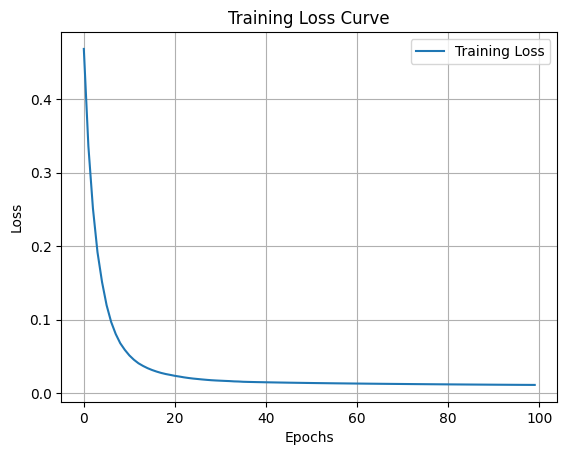


--- XGB Classification Report ---
              precision    recall  f1-score   support

           0       0.98      0.97      0.98        63
           1       0.96      0.98      0.97        50

    accuracy                           0.97       113
   macro avg       0.97      0.97      0.97       113
weighted avg       0.97      0.97      0.97       113



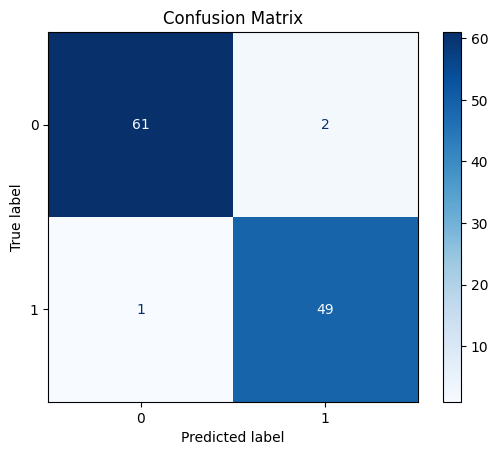

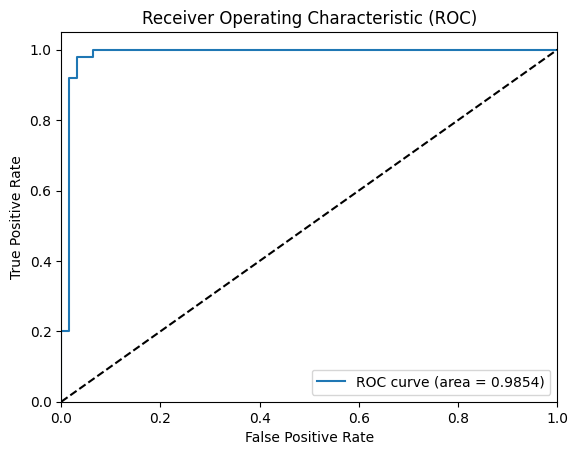

In [3]:
# Prepare data
X_train, X_test, y_train, y_test = static_processor.train_test_split(
    test_size=0.3,          # Proportion of the dataset to include in the test split
    shuffle=True,           # Whether to shuffle the data before splitting
    random_state=42,        # Seed used by the random number generator for reproducibility
    standardize=True,       # Apply feature scaling to the data
)
# Data cleaning parameters
cleaning_params = {
    'fill_missing': 'mean',  # Missing value filling method, supporting all pandas data aggregation functions
    'outlier_method': 'iqr'  # Outlier detection methods, support: iqr, zscore(3σ)
}
# model params
model_params = {}

# data cleaning
X_train, X_test = static_processor.data_cleaning(X_train, X_test, **cleaning_params)

# Train and evaluate
model = StaticClassifier(model_type='XGB')  # Model type, support: XGBoost
model.fit(X_train, y_train, model_params)
model.evaluate(X_test, y_test)


## 4. Time series data processing

In [4]:
# Initialize
TSprocessor = TSProcessor()

# Read file
TSprocessor.read_file(**config)

# Time resampling parameters
resample_params = {
    'freq': '1D',               # Resampling frequency, e.g., '1D', '2H'
    'fill_method': 'linear'     # Interpolation method for newly created time steps, support:'linear', 'time', 'nearest', 'ffill'
}

# Time resampling
TSprocessor.time_resample(**resample_params)

# Export table
TSprocessor.export('output/TS_table.xlsx')


### 5. Time series model training

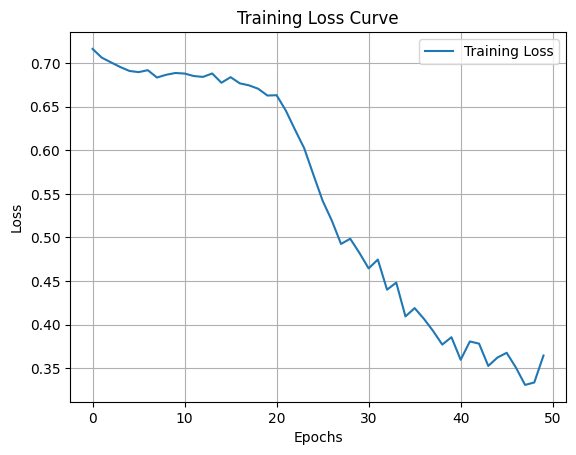


--- T-LSTM Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.69      0.79        55
           1       0.76      0.95      0.84        57

    accuracy                           0.82       112
   macro avg       0.84      0.82      0.82       112
weighted avg       0.84      0.82      0.82       112



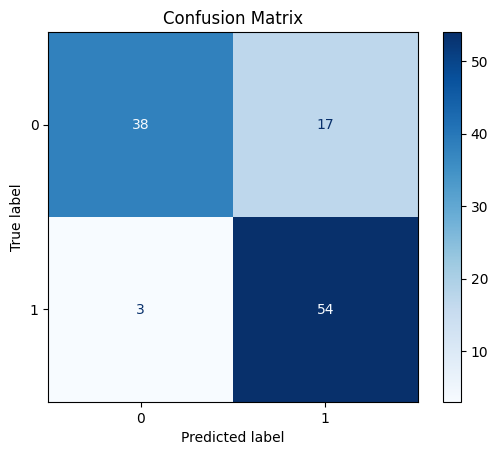

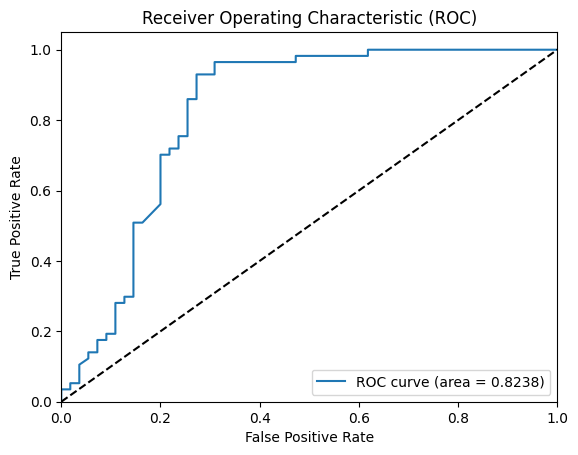

In [5]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = TSprocessor.train_test_split(
    test_size=0.3,          # Proportion of the dataset to include in the test split
    shuffle=True,           # Whether to shuffle the data before splitting
    random_state=42,        # Seed used by the random number generator for reproducibility
    standardize=True,       # Apply feature scaling to the data
)
# Data cleaning parameters
cleaning_params = {
    'fill_missing': 'mean',  # Missing value filling method, supporting all pandas data aggregation functions
    'outlier_method': 'iqr'  # Outlier detection methods, support: iqr, zscore(3σ)
}

# data cleaning
X_train, X_test = TSprocessor.data_cleaning(X_train, X_test, **cleaning_params)

# Configuration for model hyperparameters
model_params = {
    'hidden_size': 64,                      # Number of neurons in the hidden layer
    'time_index': TSprocessor.time_index,   # Column identifier for temporal data
    'epochs': 50,                           # Number of complete passes through the training dataset
    'lr': 0.0001,                           # Step size for weight updates during optimization
}

# Initialization and Run
model = TSClassifier(model_type='T-LSTM')  # Model type, support: 'T-LSTM', 'LSTM'
model.fit(X_train, y_train, model_params)
model.evaluate(X_test, y_test)
